# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from datetime import datetime
import sqlite3

In [2]:
import pandas as pd
import numpy as np
import math
import json

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Exploration

### Portfolio

In [3]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [5]:
# one-hot encode channels

mlb = MultiLabelBinarizer()
channel_df = pd.DataFrame(mlb.fit_transform(portfolio.channels), 
                          columns = mlb.classes_, 
                         index = portfolio.index)
portfolio = portfolio.merge(channel_df, left_index=True, right_index=True).drop(columns='channels')

In [6]:
# one-hot encode offer_type
offer_dummy = pd.get_dummies(portfolio.offer_type)
portfolio = pd.concat([portfolio, offer_dummy], axis=1)
portfolio.drop(columns='offer_type', inplace=True)

### Profile

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
# each row is a unique customer
profile.id.nunique()

17000

In [10]:
# investigate null values
# start with gender
profile[profile.gender.isnull()].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [11]:
profile[profile.gender.isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 16994
Data columns (total 5 columns):
age                 2175 non-null int64
became_member_on    2175 non-null int64
gender              0 non-null object
id                  2175 non-null object
income              0 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 102.0+ KB


In [12]:
profile[profile.gender.isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [13]:
profile = profile[~profile.gender.isnull()]

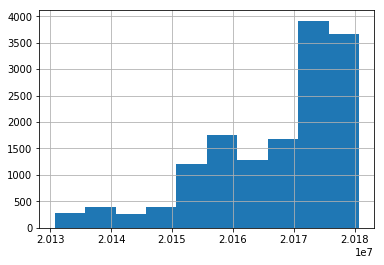

In [14]:
profile.became_member_on.hist()

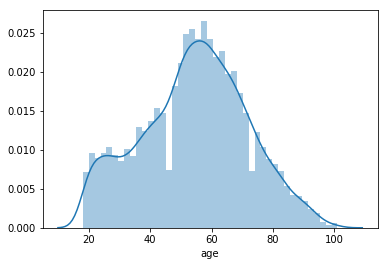

In [15]:
sns.distplot(profile.age)

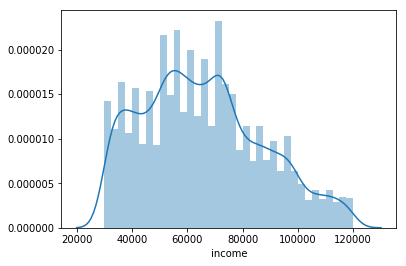

In [16]:
sns.distplot(profile.income)

In [17]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [18]:
gender_dummy = pd.get_dummies(profile.gender, prefix='gender')
profile = pd.concat([profile, gender_dummy], axis=1)
profile.drop(columns='gender', inplace=True)

In [19]:
# change became_member_on to datetime object
def datetime_convert(x):
    return datetime.strptime(str(x), '%Y%m%d')

profile['became_member_on'] = profile.became_member_on.apply(datetime_convert)


In [20]:
profile['year'] = pd.DatetimeIndex(profile.became_member_on).year
profile['month'] = pd.DatetimeIndex(profile.became_member_on).month

In [21]:
# create member time & convert to int
today = pd.to_datetime('2020-10-01')
profile['member_days'] = (today - profile.became_member_on)
profile.member_days = profile.member_days.dt.days.astype('int16')

In [22]:
profile.head()

,age,became_member_on,id,income,gender_F,gender_M,gender_O,year,month,member_days
1,55,2017-07-15,0610b486422d4921ae7d2bf64640c50b,112000.0,1,0,0,2017,7,1174
3,75,2017-05-09,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1,0,0,2017,5,1241
5,68,2018-04-26,e2127556f4f64592b11af22de27a7932,70000.0,0,1,0,2018,4,889
8,65,2018-02-09,389bc3fa690240e798340f5a15918d5c,53000.0,0,1,0,2018,2,965
12,58,2017-11-11,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,1,0,2017,11,1055


### Transcript

In [23]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [24]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [25]:
# check if all people in transcript have a profile
len(transcript[~transcript.person.isin(profile.id)])

33772

In [26]:
transcript[~transcript.person.isin(profile.id)].describe()

,time
count,33772.000000
mean,363.760038
std,200.045060
min,0.000000
25%,180.000000
50%,408.000000
75%,522.000000
max,714.000000


In [27]:
# remove those that do not have a profile
transcript = transcript[transcript.person.isin(profile.id)]

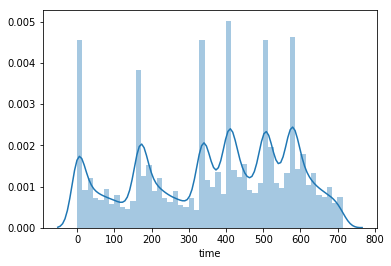

In [28]:
sns.distplot(transcript.time)

In [29]:
# investigate event
transcript.event.value_counts()

transaction        123957
offer received      66501
offer viewed        49860
offer completed     32444
Name: event, dtype: int64

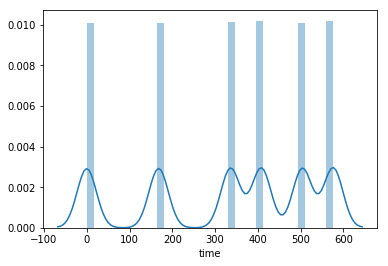

In [30]:
sns.distplot(transcript[transcript.event == 'offer received'].time)

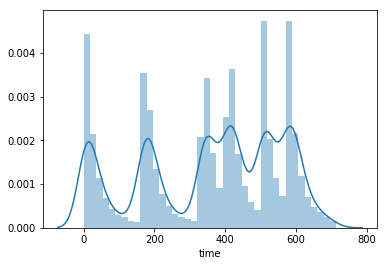

In [31]:
sns.distplot(transcript[transcript.event == 'offer viewed'].time)

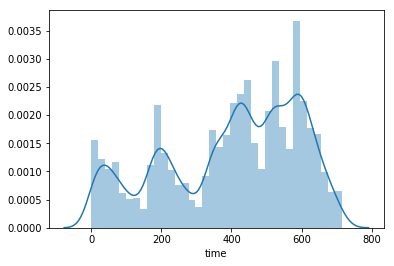

In [32]:
sns.distplot(transcript[transcript.event == 'offer completed'].time)

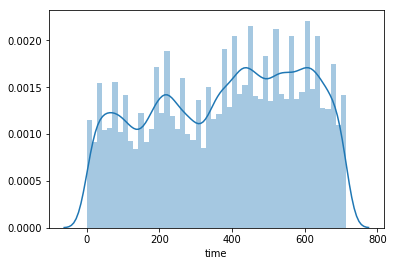

In [33]:
sns.distplot(transcript[transcript.event == 'transaction'].time)

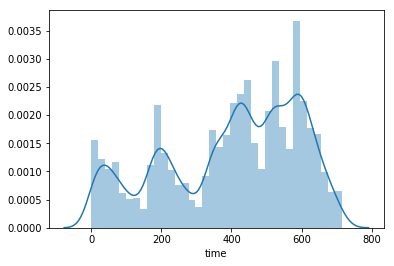

In [34]:
sns.distplot(transcript[transcript.event == 'offer completed'].time)

In [35]:
# investigate the mysterious values column

In [36]:
values = transcript.value.apply(lambda x: str(list(x.keys())))

In [37]:
values.value_counts()

['amount']                123957
['offer id']              116361
['offer_id', 'reward']     32444
Name: value, dtype: int64

In [38]:
# create columns for the keys
transcript['value_key'] = transcript.value.apply(lambda x: list(x.keys()))

In [39]:
transcript['value_key_str'] = transcript.value_key.astype(str)

In [40]:
transcript.head()

,event,person,time,value,value_key,value_key_str
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],['offer id']
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},[offer id],['offer id']
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},[offer id],['offer id']
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'},[offer id],['offer id']
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},[offer id],['offer id']


In [41]:
pd.crosstab(transcript.event, transcript.value_key_str)

value_key_str,['amount'],['offer id'],"['offer_id', 'reward']"
event,,,
offer completed,0,0,32444
offer received,0,66501,0
offer viewed,0,49860,0
transaction,123957,0,0


In [42]:
# so an offer id is attached to an initialization of the offer, and a viewing of the offer
# now how to match a transaction and its amount to an offer?

In [43]:
# investigate one person to see how we can track a single offer
transcript[transcript.person == '78afa995795e4d85b5d9ceeca43f5fef'].sort_values(by='time')

,event,person,time,value,value_key,value_key_str
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],['offer id']
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},[offer id],['offer id']
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,{'amount': 19.89},[amount],['amount']
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,"[offer_id, reward]","['offer_id', 'reward']"
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,{'amount': 17.78},[amount],['amount']
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},[offer id],['offer id']
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},[offer id],['offer id']
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,{'amount': 19.67},[amount],['amount']
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,{'amount': 29.72},[amount],['amount']
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,{'amount': 23.93},[amount],['amount']


In [44]:
# looks like there is a transaction event at the same time as an offer completed event 
# this likely indicates that they purchased that amount using the offer
# we can use this to link the amount to the offer id

# First, separate out the offer id's
transcript['offer_id'] = transcript['value'].apply(lambda x: x['offer_id'] if 'offer_id' in x else (x['offer id'] if 'offer id' in x else None))

In [45]:
# then attach an offer id to each transaction 
transcript['purchase_amount'] = transcript['value'].apply(lambda x: x['amount'] if 'amount' in x else (x['amount id'] if 'amount' in x else None))
completed = pd.merge(transcript.loc[transcript['event'] == 'offer completed', ['person', 'time', 'offer_id']], 
                    transcript.loc[transcript['event'] == 'transaction', ['person', 'time', 'purchase_amount']], 
                    on=['person', 'time'])
completed.head()

,person,time,offer_id,purchase_amount
0,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5,34.56
1,fe97aa22dd3e48c8b143116a8403dd52,0,fafdcd668e3743c1bb461111dcafc2a4,18.97
2,629fc02d56414d91bca360decdfa9288,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,33.90
3,676506bad68e4161b9bbaffeb039626b,0,ae264e3637204a6fb9bb56bc8210ddfd,18.01
4,8f7dd3b2afe14c078eb4f6e6fe4ba97d,0,4d5c57ea9a6940dd891ad53e9dbe8da0,19.11


In [46]:
# make a separate dataframe to describe the process of receiving, and viewing an offer
# get recieved and viewed offers and merge into one df
viewed = pd.merge(transcript.loc[transcript['event'] == 'offer received', ['person', 'time', 'offer_id']],
                  transcript.loc[transcript['event'] == 'offer viewed', ['person', 'time', 'offer_id']],
                  on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# remove those that were not viewed
viewed = viewed[~viewed.time_viewed.isna()]

# create time to view columns
viewed['time_to_view'] = viewed.time_viewed - viewed.time_received

viewed.head()

,person,time_received,offer_id,time_viewed,time_to_view
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,6.0,6.0
1,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,18.0,18.0
2,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0
3,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,504.0,504.0
5,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,18.0,18.0


In [47]:
# it seems you can receive the same offer multiple times
# how do we deal with this?

# get first instance of offer_id when event == completed
# can group by person, offer_id, event, and use count

grouped_count = transcript.groupby(by=['person', 'offer_id', 'event', 'time']).count().reset_index().drop(columns=['value', 'value_key', 'value_key_str', 'purchase_amount'])
sample = grouped_count[grouped_count.person == '004c5799adbf42868b9cff0396190900'].head(20).sort_values(by='time')
sample.head()

,person,offer_id,event,time
84,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,offer received,168
86,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,offer viewed,174
82,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,offer completed,222
74,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,offer completed,336
75,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,offer received,336


In [48]:
# use cumcount to get number of instances of each completion
transcript.sort_values(by=['person', 'offer_id', 'time'], inplace=True)
transcript['event_count'] = transcript.groupby(by=['person', 'offer_id', 'event']).cumcount()+1

# test with person that completed an offer multiple times
transcript[transcript.person == '004c5799adbf42868b9cff0396190900'].drop(columns=['value', 'value_key', 'value_key_str'])

# looks like it works! 
# event type transaction is weird but we'll drop that later

,event,person,time,offer_id,purchase_amount,event_count
119263,offer received,004c5799adbf42868b9cff0396190900,336,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1
124134,offer completed,004c5799adbf42868b9cff0396190900,336,ae264e3637204a6fb9bb56bc8210ddfd,NaN,1
163335,offer received,004c5799adbf42868b9cff0396190900,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1
164078,offer viewed,004c5799adbf42868b9cff0396190900,408,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1
177710,offer completed,004c5799adbf42868b9cff0396190900,432,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1
214247,offer received,004c5799adbf42868b9cff0396190900,504,f19421c1d4aa40978ebb69ca19b0e20d,NaN,2
222424,offer viewed,004c5799adbf42868b9cff0396190900,516,f19421c1d4aa40978ebb69ca19b0e20d,NaN,2
239694,offer completed,004c5799adbf42868b9cff0396190900,558,f19421c1d4aa40978ebb69ca19b0e20d,NaN,2
55278,offer received,004c5799adbf42868b9cff0396190900,168,fafdcd668e3743c1bb461111dcafc2a4,NaN,1
69783,offer viewed,004c5799adbf42868b9cff0396190900,174,fafdcd668e3743c1bb461111dcafc2a4,NaN,1


In [49]:
# create cycle id to identify each cycle of viewing and completing an offer
transcript['cycle_id'] =  transcript.event_count.map(str) + transcript.person + transcript.offer_id

In [50]:
# get info for each offer cycle
offers = transcript[transcript.event != 'transaction']
offers = offers.pivot_table(values = ['time'],
                            index = ['cycle_id', 'person','offer_id'], 
                            columns = 'event').reset_index()
offers.columns = ['cycle_id', 'person', 'offer_id', 'offer_completed', 'offer_received', 'offer_viewed']
offers = offers[['cycle_id', 'person', 'offer_id', 'offer_received', 'offer_viewed', 'offer_completed']]

offers[offers.person == '004c5799adbf42868b9cff0396190900']

,cycle_id,person,offer_id,offer_received,offer_viewed,offer_completed
29,1004c5799adbf42868b9cff0396190900ae264e3637204...,004c5799adbf42868b9cff0396190900,ae264e3637204a6fb9bb56bc8210ddfd,336.0,NaN,336.0
30,1004c5799adbf42868b9cff0396190900f19421c1d4aa4...,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,408.0,408.0,432.0
31,1004c5799adbf42868b9cff0396190900fafdcd668e374...,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,168.0,174.0,222.0
55225,2004c5799adbf42868b9cff0396190900f19421c1d4aa4...,004c5799adbf42868b9cff0396190900,f19421c1d4aa40978ebb69ca19b0e20d,504.0,516.0,558.0
55226,2004c5799adbf42868b9cff0396190900fafdcd668e374...,004c5799adbf42868b9cff0396190900,fafdcd668e3743c1bb461111dcafc2a4,576.0,648.0,576.0


In [51]:
# join with amount data
offers = offers.merge(completed, 
                     how='left', 
                     left_on=['person', 'offer_id', 'offer_completed'], 
                     right_on=['person', 'offer_id', 'time'])
offers.drop(columns='time', inplace=True)
offers.head()

,cycle_id,person,offer_id,offer_received,offer_viewed,offer_completed,purchase_amount
0,10009655768c64bdeb2e877511632db8f2906b810c7d44...,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,10.27
1,10009655768c64bdeb2e877511632db8f3f207df678b14...,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN
2,10009655768c64bdeb2e877511632db8f5a8bc65990b24...,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN
3,10009655768c64bdeb2e877511632db8ff19421c1d4aa4...,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,8.57
4,10009655768c64bdeb2e877511632db8ffafdcd668e374...,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,14.11


In [52]:
# check which transactions were influenced by an offer

# if offer was both viewed and completed, then it was influenced
offers['infl_trx'] = 'Not Influenced'
offers.loc[offers.offer_viewed.notnull() & offers.offer_completed.notnull(), ['infl_trx']] = 'Influenced'

# offers that were not completed can have a separate value
offers.loc[offers.offer_completed.isnull(), ['infl_trx']] = 'Not Completed'
offers.head()

,cycle_id,person,offer_id,offer_received,offer_viewed,offer_completed,purchase_amount,infl_trx
0,10009655768c64bdeb2e877511632db8f2906b810c7d44...,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,10.27,Not Influenced
1,10009655768c64bdeb2e877511632db8f3f207df678b14...,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,Not Completed
2,10009655768c64bdeb2e877511632db8f5a8bc65990b24...,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN,Not Completed
3,10009655768c64bdeb2e877511632db8ff19421c1d4aa4...,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,8.57,Influenced
4,10009655768c64bdeb2e877511632db8ffafdcd668e374...,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,14.11,Influenced


### Merged data

In [53]:
# merge offers with offer portfolio
offers = offers.merge(portfolio, 
                      how='left',
                      left_on='offer_id', 
                      right_on='id').drop(columns='id')

In [54]:
offers.head()

,cycle_id,person,offer_id,offer_received,offer_viewed,offer_completed,purchase_amount,infl_trx,difficulty,duration,reward,email,mobile,social,web,bogo,discount,informational
0,10009655768c64bdeb2e877511632db8f2906b810c7d44...,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,10.27,Not Influenced,10,7,2,1,1,0,1,0,1,0
1,10009655768c64bdeb2e877511632db8f3f207df678b14...,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,Not Completed,0,4,0,1,1,0,1,0,0,1
2,10009655768c64bdeb2e877511632db8f5a8bc65990b24...,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN,Not Completed,0,3,0,1,1,1,0,0,0,1
3,10009655768c64bdeb2e877511632db8ff19421c1d4aa4...,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,8.57,Influenced,5,5,5,1,1,1,1,1,0,0
4,10009655768c64bdeb2e877511632db8ffafdcd668e374...,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,14.11,Influenced,10,10,2,1,1,1,1,0,1,0


In [55]:
# merge offers with customer profiles
offers = offers.merge(profile, 
                     how='left', 
                     left_on='person', 
                     right_on='id')
offers.drop(columns='id', inplace=True)

### Final Exploratory Analysis

Now that the data has been completely cleaned we can do some final exploration of the data, in particular: which characteristics of both the marketing campaigns, and the people recieving them are more likely to complete an offer.

In [170]:
offers.head()

,cycle_id,person,offer_id,offer_received,offer_viewed,offer_completed,purchase_amount,infl_trx,difficulty,duration,...,informational,age,became_member_on,income,gender_F,gender_M,gender_O,year,month,member_days
0,10009655768c64bdeb2e877511632db8f2906b810c7d44...,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,10.27,Not Influenced,10,7,...,0,33,2017-04-21,72000.0,0,1,0,2017,4,1259
1,10009655768c64bdeb2e877511632db8f3f207df678b14...,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,Not Completed,0,4,...,1,33,2017-04-21,72000.0,0,1,0,2017,4,1259
2,10009655768c64bdeb2e877511632db8f5a8bc65990b24...,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN,Not Completed,0,3,...,1,33,2017-04-21,72000.0,0,1,0,2017,4,1259
3,10009655768c64bdeb2e877511632db8ff19421c1d4aa4...,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,8.57,Influenced,5,5,...,0,33,2017-04-21,72000.0,0,1,0,2017,4,1259
4,10009655768c64bdeb2e877511632db8ffafdcd668e374...,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,14.11,Influenced,10,10,...,0,33,2017-04-21,72000.0,0,1,0,2017,4,1259


In [171]:
offers.columns

Index(['cycle_id', 'person', 'offer_id', 'offer_received', 'offer_viewed',
       'offer_completed', 'purchase_amount', 'infl_trx', 'difficulty',
       'duration', 'reward', 'email', 'mobile', 'social', 'web', 'bogo',
       'discount', 'informational', 'age', 'became_member_on', 'income',
       'gender_F', 'gender_M', 'gender_O', 'year', 'month', 'member_days'],
      dtype='object')

In [56]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 67251 entries, 0 to 67250
Data columns (total 27 columns):
cycle_id            67251 non-null object
person              67251 non-null object
offer_id            67251 non-null object
offer_received      67251 non-null float64
offer_viewed        50377 non-null float64
offer_completed     33194 non-null float64
purchase_amount     33194 non-null float64
infl_trx            67251 non-null object
difficulty          67251 non-null int64
duration            67251 non-null int64
reward              67251 non-null int64
email               67251 non-null int32
mobile              67251 non-null int32
social              67251 non-null int32
web                 67251 non-null int32
bogo                67251 non-null uint8
discount            67251 non-null uint8
informational       67251 non-null uint8
age                 67251 non-null int64
became_member_on    67251 non-null datetime64[ns]
income              67251 non-null float64
gender_

In [57]:
offers.describe()

,offer_received,offer_viewed,offer_completed,purchase_amount,difficulty,duration,reward,email,mobile,social,...,discount,informational,age,income,gender_F,gender_M,gender_O,year,month,member_days
count,67251.000000,50377.000000,33194.000000,33194.000000,67251.000000,67251.000000,67251.000000,67251.0,67251.000000,67251.000000,...,67251.000000,67251.000000,67251.000000,67251.000000,67251.000000,67251.000000,67251.000000,67251.000000,67251.000000,67251.000000
mean,333.638578,355.672787,402.306381,20.794754,7.748970,6.520944,4.208978,1.0,0.897578,0.597671,...,0.402938,0.197767,54.380782,65432.395057,0.413079,0.573122,0.013799,2016.620853,6.690384,1320.382597
std,196.071884,199.031409,191.807405,40.247470,5.553327,2.203732,3.393948,0.0,0.303205,0.490371,...,0.490492,0.398318,17.396976,21635.369425,0.492391,0.494628,0.116657,1.197634,3.491869,418.904313
min,0.000000,0.000000,0.000000,0.150000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000,...,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,2013.000000,1.000000,798.000000
25%,168.000000,180.000000,240.000000,11.430000,5.000000,5.000000,2.000000,1.0,1.000000,0.000000,...,0.000000,0.000000,42.000000,49000.000000,0.000000,0.000000,0.000000,2016.000000,4.000000,1006.000000
50%,408.000000,408.000000,438.000000,17.090000,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,...,0.000000,0.000000,55.000000,64000.000000,0.000000,1.000000,0.000000,2017.000000,7.000000,1156.000000
75%,504.000000,516.000000,564.000000,23.647500,10.000000,7.000000,5.000000,1.0,1.000000,1.000000,...,1.000000,0.000000,66.000000,80000.000000,1.000000,1.000000,0.000000,2017.000000,10.000000,1596.000000
max,576.000000,714.000000,714.000000,1015.730000,20.000000,10.000000,10.000000,1.0,1.000000,1.000000,...,1.000000,1.000000,101.000000,120000.000000,1.000000,1.000000,1.000000,2018.000000,12.000000,2621.000000


In [ ]:
# examine relationships between influenced transactions and characteristics of customers and marketing events

In [100]:
def percentage_influenced(column, offers=offers):
    grouped = offers[[column, 'infl_trx', 'cycle_id']].groupby([column, 'infl_trx']).count()
    percentages = grouped.groupby(level=0).apply(lambda x: 100 * x/float(x.sum())).reset_index()
    percentages.rename(columns={'cycle_id': 'percent_influenced'}, inplace=True)
    return percentages.loc[percentages.infl_trx == 'Influenced', [column, 'percent_influenced']]

In [101]:
# minimum spend of marketing event
percentage_influenced('difficulty')
# looks like $7 does the best

,difficulty,percent_influenced
1,5,50.376500
4,7,71.379771
7,10,52.895939
10,20,23.765970


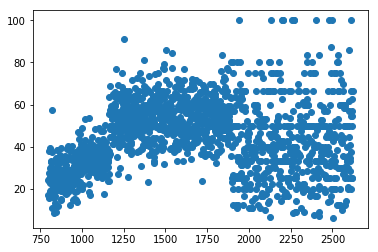

In [102]:
# number of days as a member
grouped = percentage_influenced('member_days')
plt.scatter(x=grouped.member_days, y=grouped.percent_influenced)

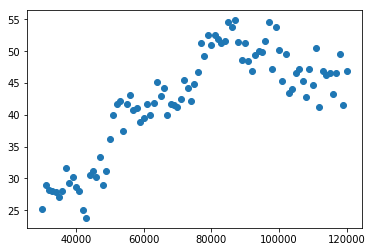

In [103]:
# income
grouped = percentage_influenced('income')
plt.scatter(x=grouped.income, y=grouped.percent_influenced)
# there's a pretty strong relationship here!

In [112]:
# gender
grouped_f = percentage_influenced('gender_F', offers=offers[offers.gender_F==1]).rename(columns={'gender_F': 'gender_drop'})
grouped_f['gender'] = 'F'
grouped_m = percentage_influenced('gender_M', offers=offers[offers.gender_M==1]).rename(columns={'gender_M': 'gender_drop'})
grouped_m['gender'] = 'M'
grouped_o = percentage_influenced('gender_O', offers=offers[offers.gender_O==1]).rename(columns={'gender_O': 'gender_drop'})
grouped_o['gender'] = 'O'
grouped = pd.concat([grouped_f, grouped_m, grouped_o]).drop(columns='gender_drop')
grouped
# seems that M is less likely to be influenced overall

,percent_influenced,gender
0,46.288697,F
0,36.624030,M
0,49.892241,O


In [130]:
# reward amount
grouped = percentage_influenced('reward')
grouped.sort_values(by='percent_influenced')
# $3 reward does the best by far

,reward,percent_influenced
7,5,41.347717
10,10,49.203869
1,2,56.577873
4,3,71.379771


In [121]:
# marketing offer type

# create this helper function first
def reverse_onehot(column, indicator, offers=offers):
    grouped = percentage_influenced(column, offers=offers[offers[column]==1]).rename(columns={column: 'drop'})
    grouped[indicator] = column
    grouped.drop(columns='drop', inplace=True)
    return grouped

In [127]:
email = reverse_onehot('email', 'offer_type')
mobile = reverse_onehot('mobile', 'offer_type')
social = reverse_onehot('social', 'offer_type')
web = reverse_onehot('web', 'offer_type')
bogo = reverse_onehot('bogo', 'offer_type')
discount = reverse_onehot('discount', 'offer_type')
pd.concat([email, mobile, social, web, bogo, discount]).sort_values(by='percent_influenced')
# looks like discounts, social, and bogo do the best
# they are all very close however, so a proper A-B test in future would be needed to confirm 

,percent_influenced,offer_type
0,40.799393,email
0,42.743071,mobile
0,44.792731,web
0,49.789595,bogo
0,50.801115,social
0,51.915270,discount
